In [10]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import precision_recall_curve

In [11]:
# 1. Dataset Paths and Parameters
# -------------------------------
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Valid labels to consider
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create directories if they do not exist
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

In [12]:
# 2. Define Augmentations and Processing Functions
# -------------------------------
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.RandomResizedCrop(height=200, width=200, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)



<ipython-input-12-2ab85955be45>:9: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),


In [13]:
# 3. Expand Dataset (Augment Images)
# -------------------------------
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        img = cv2.imread(img_path)
        if img is None:
            continue
        augmented = augmentations(image=img)["image"]
        cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
        images.append(img_path)

In [14]:
# 4. Apply Additional Processing Techniques
# -------------------------------
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
        cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
        cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
        cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
        cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))

In [15]:
# 5. Load Processed Dataset and Create Train/Val/Test Splits
# -------------------------------
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    for img_file in os.listdir(label_path):
        all_images.append(os.path.join(label_path, img_file))
        all_labels.append(label_map[label])

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(
    temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights to address any imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings (required by ImageDataGenerator)
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

In [16]:
# 6. Create Data Generators with Enhanced Augmentation
# -------------------------------
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

train_df = pd.DataFrame({"filename": train_imgs, "class": train_labels})
val_df = pd.DataFrame({"filename": val_imgs, "class": val_labels})
test_df = pd.DataFrame({"filename": test_imgs, "class": test_labels})

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(224, 224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.


In [17]:
# 7. Build the ResNet-based Model with Transfer Learning & Regularization
# -------------------------------
# Use ResNet50 as base model with ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze the base model for initial training
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(len(valid_labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=out)

# Compile with Adam optimizer using an initial learning rate
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,123,014 (92.02 MB)

 Trainable params: 530,694 (2.02 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

In [18]:
# 8. Define Callbacks to Prevent Overfitting
# -------------------------------
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
# Changed the filename to end with '.keras' instead of '.h5'
checkpoint = ModelCheckpoint('best_resnet_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
callbacks = [early_stop, reduce_lr, checkpoint]


In [19]:
# 9. Train the Model (Initial Phase with Base Frozen)
# -------------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - accuracy: 0.1876 - loss: 2.7388
Epoch 1: val_loss improved from inf to 1.97695, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 559ms/step - accuracy: 0.1876 - loss: 2.7377 - val_accuracy: 0.2061 - val_loss: 1.9769 - learning_rate: 1.0000e-04
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.2110 - loss: 2.4202
Epoch 2: val_loss improved from 1.97695 to 1.84343, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 29s 404ms/step - accuracy: 0.2111 - loss: 2.4207 - val_accuracy: 0.2398 - val_loss: 1.8434 - learning_rate: 1.0000e-04
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.2068 - loss: 2.4434
Epoch 3: val_loss improved from 1.84343 to 1.72032, saving model to best_resnet_model.keras
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 404ms/step - accuracy: 0.2072 - loss: 2.4427 - val_accuracy: 0.2266 - val_loss: 1.7203 - learning_rate: 1.0000e-04
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 28

In [20]:
# 10. Fine-tune the Model by Unfreezing Part of the Base
# -------------------------------
# Unfreeze the base model for fine-tuning
base_model.trainable = True
# Optionally, freeze the earlier layers (e.g., first 100 layers) to prevent overfitting
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.2576 - loss: 2.4219
Epoch 1: val_loss did not improve from 1.31094
65/65 ━━━━━━━━━━━━━━━━━━━━ 75s 658ms/step - accuracy: 0.2577 - loss: 2.4206 - val_accuracy: 0.1477 - val_loss: 3.1620 - learning_rate: 1.0000e-05
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.3189 - loss: 2.2168
Epoch 2: val_loss did not improve from 1.31094
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 399ms/step - accuracy: 0.3186 - loss: 2.2177 - val_accuracy: 0.1374 - val_loss: 4.0142 - learning_rate: 1.0000e-05
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.3171 - loss: 2.1861
Epoch 3: val_loss did not improve from 1.31094
65/65 ━━━━━━━━━━━━━━━━━━━━ 28s 404ms/step - accuracy: 0.3174 - loss: 2.1854 - val_accuracy: 0.2164 - val_loss: 3.3674 - learning_rate: 1.0000e-05
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3186 - loss: 2.1162
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.



In [21]:
# 11. Evaluate the Model on Test Data
# -------------------------------
test_loss, test_accuracy = model.evaluate(test_gen)
print("Final Test Accuracy:", test_accuracy)

22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.1166 - loss: 3.2039
Final Test Accuracy: 0.1315789520740509


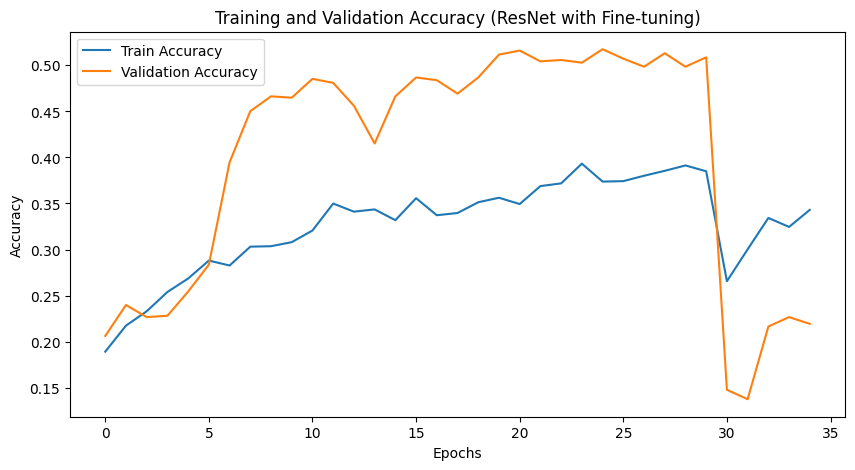

In [22]:
# 12. Plot Training and Validation Accuracy
# -------------------------------
plt.figure(figsize=(10, 5))
# Concatenate history from both phases
train_acc = history.history['accuracy'] + history_finetune.history['accuracy']
val_acc = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy (ResNet with Fine-tuning)')
plt.show()

22/22 ━━━━━━━━━━━━━━━━━━━━ 12s 429ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


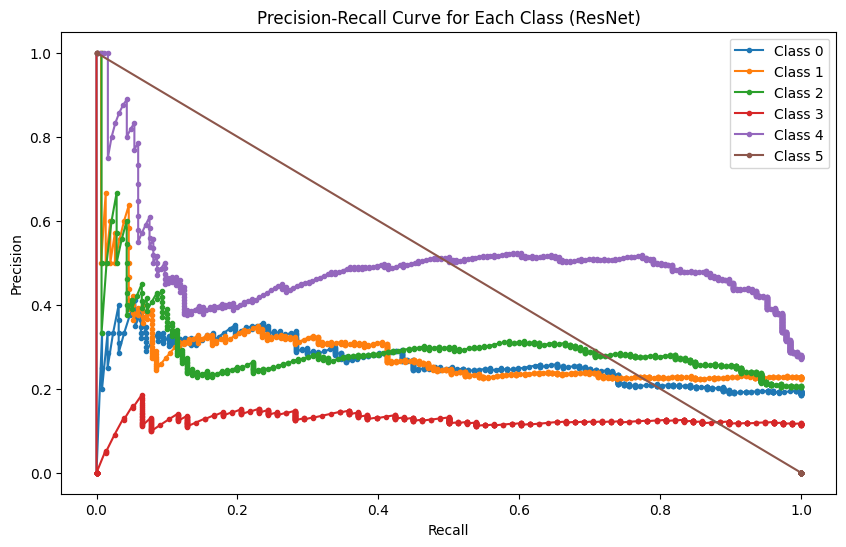

In [23]:
# 13. Compute and Plot Precision-Recall Curves for Each Class
# -------------------------------
y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes=len(valid_labels))
y_probs = model.predict(test_gen)

plt.figure(figsize=(10, 6))
for i in range(len(valid_labels)):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
    plt.plot(recall, precision, marker='.', label=f'Class {i}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class (ResNet)')
plt.legend()
plt.show()